# Libs

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.integrate import odeint
from scipy.special import jv, yn
from scipy.linalg import solve
from tqdm import tqdm
import math
from matplotlib.lines import Line2D
from numpy.linalg import eig
import pandas as pd
from IPython.display import display, Math
import os
import scipy as sc
from cycler import cycler
from sympy.physics.quantum import TensorProduct

from scipy.special import sph_harm, spherical_jn, genlaguerre, factorial
from math import sqrt, pi
#from scipy.special import coulombf  # compiled, fast
from sympy.physics.wigner import wigner_3j


from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
import sympy as sp
from sympy import Matrix, latex
from sympy import symbols, series, simplify
dir = os.getcwd()
from scipy.optimize import curve_fit
from scipy.special import jn  # Or jv for real-valued order
from collections import Counter
from scipy.constants import epsilon_0, e, pi, electron_volt, hbar
from scipy.special import sph_harm
from sympy.physics.wigner import wigner_3j
from math import sqrt, pi

def ev_to_hz(E_eV):
    """Convert energy (in eV) to frequency (in Hz)."""
    h_eVs = 4.135667696e-15  # Planck constant in eV·s
    return E_eV / h_eVs
def ev_to_joules(linewidth_ev):
    eV_to_J = 1.602176634e-19  # 1 eV in joules
    return linewidth_ev * eV_to_J
    
plt.rcParams['lines.linewidth'] = 3             # 1) Line width
plt.rcParams['axes.titlesize'] = 20             # 2) Font size for axes title
plt.rcParams['axes.labelsize'] = 20             # 3) Font size for axes labels
plt.rcParams['legend.fontsize'] = 20            # 4) Font size for legends
plt.rcParams['xtick.labelsize'] = 20            # Tick label size (x)
plt.rcParams['ytick.labelsize'] = 20            # Tick label size (y)

eps_r=7.5
mu = 0.355859094177
a_bohr = 5.29177210903e-11 

# Functions

## Rydberg Functions

In [47]:
def exciton_E(n,l):
  # find E_nl

  # For high l, approximate quantum defects by those of the F-states 
  l = min(l,3) 

  # Rydberg energy, Ry = 0.0860748181165 eV = 0.003163191367014211 a.u.
  # atomic units are necessary here because we set hbar = 1
  Ry = 0.003163191367014211

  # Set up Rydberg-Ritz array rr as provided by Sjard Ole
  rr = np.array([[0.52052052, -1.33514662, 6.20644113, -9.612849, 1.8973464],
		[0.30074225, -2.15876755, 24.97393231, -140.95522895, 239.08434163],
		[1.69167237e-01, -2.82492680e+00, 6.14693460e+01, -7.27181020e+02, 2.91021663e+03],
		[1.15238212e-01, -3.33882619e+00, 1.12006356e+02, -2.17598154e+03, 1.50127611e+04]])

  delta_nl = rr[l][0] + rr[l][1]/(n-rr[l][0])**2 + rr[l][2]/(n-rr[l][0])**4 + rr[l][3]/(n-rr[l][0])**6 + rr[l][4]/(n-rr[l][0])**8
  E_nl = -Ry/(n-delta_nl)**2
  
  return E_nl

def psi(n, l, xmin, xmax, nsteps):
  # find psi_nl
  # Reduced mass given by Sjard Ole, in a.u., i.e. in m_e
    
  if l == 0:
    prefix = 's'
  elif l == 1:
    prefix = 'p'
  elif l == 2:
    prefix = 'd'
  elif l == 3:
    prefix = 'f'
  else:
    prefix = 'x'
  
  infile = 'koeffizienten/' + prefix + '/' + prefix + str(n) + '.txt'
  
  try:
    open(infile)
    #print 'n=',n,'l=',l,': Found Cu2O wavefuction'
    eta = l+1
  except IOError:
    infile = 'koeffizienten/default.txt'
    eta = n
    #print 'n=',n,'l=',l,': Using hydrogenic wavefunction'
  
  ## Adjust boundaries as given:
  ## This range must be sufficient for all components eta
  #nsteps = 500
  #xmin = n*n - n*np.sqrt(n*n-(l-1)*(l-1))
  #if xmin < 2.08:
      #xmin = np.floor( np.sqrt(2.08) )
  #else:
      #xmin = np.floor( np.sqrt(xmin) )
  ## Small reduced mass --> R streched by 21.07 --> xmax = (rmax)^(1/2) streched by ca. 5
  #xmax = np.sqrt( 2*n*(n+15) ) * 5
  
  # nsteps - 1 because endpoints are not included, dx approx 0.1
  dx = (xmax - xmin)/(nsteps-1)
  x = np.linspace(xmin,xmax,nsteps)
  y = np.zeros_like(x)
  
  # Definition in Sjard Oles notes
  coeffs_vec = np.loadtxt(infile, comments='#', ndmin=1)
  
  for coeff in coeffs_vec:
  
    # Step 1: Find normalized and transformed functions R
    # Use transformation as in pairinteraction: rho = 2*r/n, r = x^2
    # explained in Rick's thesis, Ref. 103, but with missing factor of 2
    r = x**2
    rho = 2.0 * r * np.sqrt(2.0*mu*np.abs(exciton_E(n,l)))
    ycurr = np.exp(-rho/2) * genlaguerre(eta-l-1, 2*l+1)(rho) * np.power(rho,l)
    # Transformation: y(r) = r^(3/4)*R(r) [Rick --> Bhatti]
    ycurr = ycurr * np.power(r, 3.0/4.0)
    # Normalize
    normlag = np.sum((ycurr*x)**2) * dx
    # VALENTIN: This factor of 2 is due to transformation but forgotten in Bhatti (4)
    normlag = np.sqrt(2*normlag)
    ycurr = ycurr/normlag
    
    # Step 2: Form superposition
    y += coeff*np.power(-1.0,eta)/np.power(eta, 0.5)*ycurr
    
    eta = eta + 1
  
  # Normalize again (c.f. Sjard Ole's comment)
  normlag = np.sum((y*x)**2) * dx
  # factor 2, s.a.
  normlag = np.sqrt(2*normlag)
  y = y/normlag
  
  # return the transformed radial wavefunction (psi = R)
  return x, y
    
def rangex(n, l):
  # determine the range in x (scaled) for a single-particle wavefunction
    
  # This range must be sufficient for all components eta (works well)
  xmin = n*n - n*np.sqrt(n*n-(l-1)*(l-1))
  if xmin < 2.08:
      xmin = np.floor( np.sqrt(2.08) )
  else:
      xmin = np.floor( np.sqrt(xmin) )
  # Small reduced mass --> R streched by 21.07 --> xmax = (rmax)^(1/2) streched by ca. 5
  xmax = np.sqrt( 2*n*(n+15) ) * 5
  return xmin, xmax
    
def exciton_R(n,l):
    xmin, xmax = rangex(n, l)
    nsteps = round((xmax - xmin) / 0.1)
    x, R_cu2o = psi(n, l, xmin, xmax, nsteps)
    r_vals_cu2o = x**2  
    R_cu2o = R_cu2o / r_vals_cu2o**(3/4) 
    
    integrand = (r_vals_cu2o**2) * R_cu2o * R_cu2o
    norm = np.trapz(integrand, r_vals_cu2o)
    return R_cu2o, r_vals_cu2o, norm

def angmom(l, m, lp, mp, q):
    """Returns <l m | Y_1^q | l' m'> (up to real prefactor)"""
    """Returns for q=0: <Y_{lm}|cosθ|Y_{lp,m}> """
    prefactor = np.sqrt(4*np.pi/3)* (-1)**m * sqrt((2 * l + 1) * (2 * lp + 1) * 3 / (4 * pi))
    return (
        prefactor
        * float(wigner_3j(l, 1, lp, 0, 0, 0))
        * float(wigner_3j(l, 1, lp, -m, q, mp))
    )

def exciton_radmom(ni, li, nf, lf):
  # calculate the single-particle radial moment <ni li|r^k|nf lf> = 2 \int_0^inf y_{ni li}^* x^{2+2k} y_{nf lf} dx
  
  # Extend support to cover both states
  xmini, xmaxi = rangex(ni, li)
  xminf, xmaxf = rangex(nf, lf)
  
  xmin = min(xmini, xminf)
  xmax = max(xmaxi, xmaxf)
  # dx is set to be roughly (because of round) 0.1
  nsteps = round((xmax-xmin)/0.1)

  # xi = xf = x
  x, psii = psi(ni, li, xmin, xmax, nsteps)
  x, psif = psi(nf, lf, xmin, xmax, nsteps)
  
  dx = (xmax - xmin)/(nsteps-1)
  radial_element = 2*np.sum(np.conjugate(psii) * x**4 * psif) * dx
  
  return radial_element

## Hydrogen Functions

In [73]:
def hydrogen_E(n):
    return -1.0 / (2.0 * n**2)

def hydrogen_R(n, l):
    """Hydrogen radial wavefunction R_{nl}(r) in a.u."""
    Nr=2000
    r = np.linspace(1e-12, 100.0 * n, Nr)
    rho = 2.0 * r / n
    pref = 2.0 / n**2 * sqrt(factorial(n - l - 1) / factorial(n + l))
    L = genlaguerre(n - l - 1, 2*l + 1)(rho)
    Rnl =  pref * (rho**l) * np.exp(-rho/2.0) * L
    
    integrand = (r**2) * Rnl * Rnl
    norm = np.trapz(integrand, r)

    return Rnl, r, norm

def radial_integral_nl_to_lp(r, Rnl, RElp):
    """Radial integral ∫ r^3 R_{nl}(r) R_{E,lp}(r) dr"""
    integrand = (r**3) * Rnl * RElp
    return np.trapz(integrand, r)

## Continuum Functions

In [197]:
def plane_R(k, lk, r):
    '''
        returns energy-normalized radial plane waves (spherical bessels)
    '''    
    return sqrt(2/pi) * sqrt(k) * spherical_jn(lk, k * r)

# Spectrum: Bound and Continuum States

## Bound States

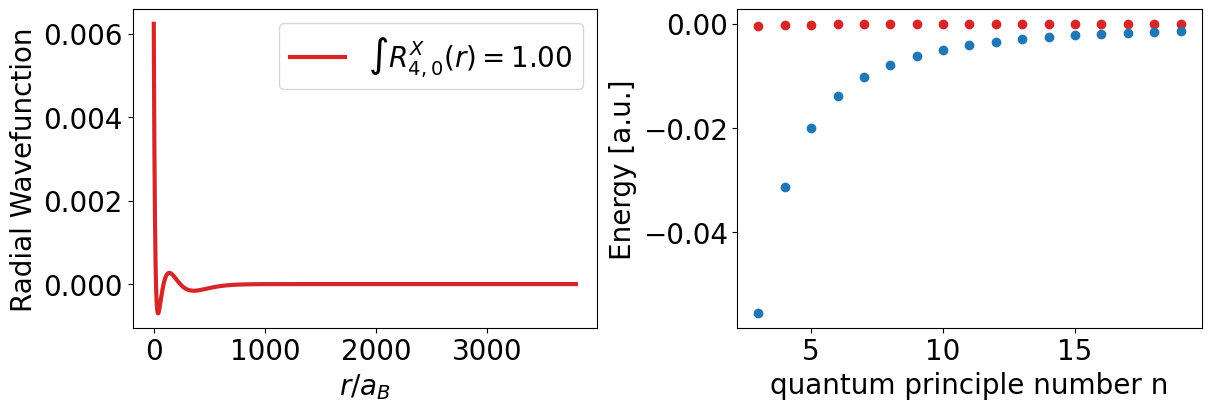

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),constrained_layout=True)

n=4; l=0;
ex_Rnl, ex_r_coord, x_norm = exciton_R(n,l)
h_Rnl, h_r_coord, h_norm = hydrogen_R(n, l)

ax[0].plot(ex_r_coord, ex_Rnl, color="C3", label=f"$\int R^X_{{{n},{l}}}(r) = {x_norm:.2f}$")
#ax[0].plot(h_r_coord,h_Rnl, color="C0", label=f"$\int  R^H_{{{n},{l}}}(r) = {h_norm:.2f}$")

for n in np.arange(3,20,1):  
    ax[1].scatter(n,  exciton_E(n, l), color="C3")
    ax[1].scatter(n,  hydrogen_E(n), color="C0")

ax[0].legend(); ax[0].set_xlabel(f"$r/a_B$"); ax[0].set_ylabel("Radial Wavefunction");
ax[1].set_xlabel(f"quantum principle number n"); ax[1].set_ylabel(f"Energy [a.u.]")
plt.show()

## Continuum States

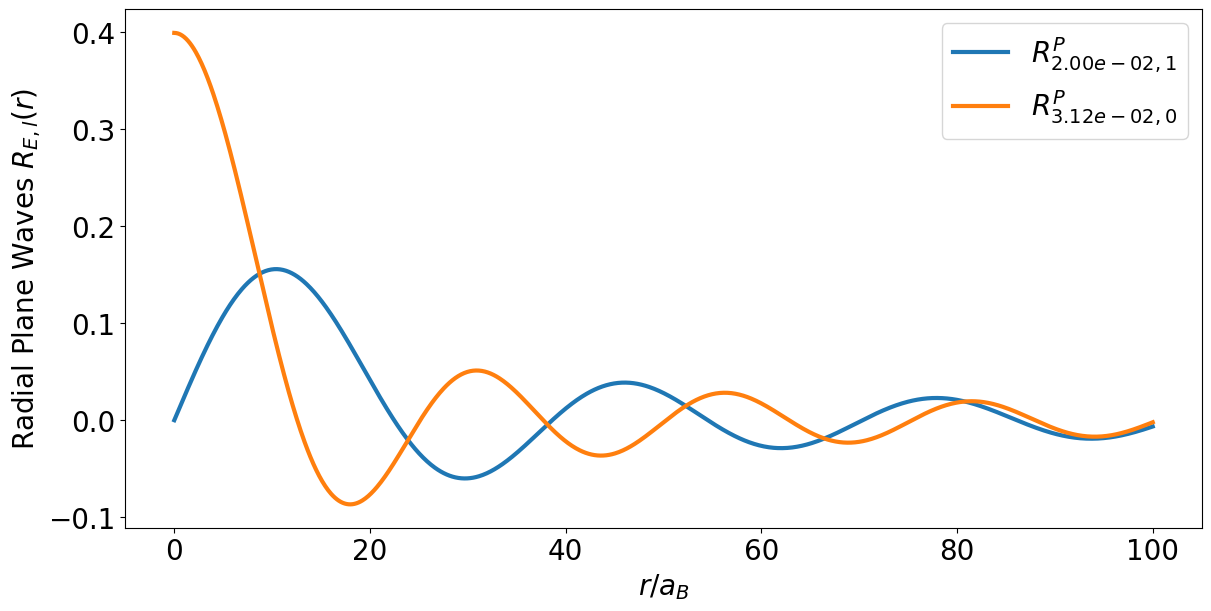

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6),constrained_layout=True)

k1=0.2; Ek1 = k1**2/2; lk1=1;
k2=0.25; Ek2 = k2**2/2; lk2=0;

r_max=1e2
r = np.linspace(1e-12,r_max,1000) # in  a.u.
p_R1 = plane_R(k1, lk1, r)
p_R2 = plane_R(k2, lk2, r)

#integrand = (r**2) * p_R1 * p_R2
#print(np.trapz(integrand, r))

ax.plot(r, p_R1, label=f"$R^P_{{{Ek1:.2e},{lk1}}}$", color="C0")
ax.plot(r, p_R2, label=f"$R^P_{{{Ek2:.2e},{lk2}}}$", color="C1")

ax.legend(); ax.set_xlabel(f"$r/a_B$"); ax.set_ylabel(r"Radial Plane Waves $R_{E,l}(r)$");
plt.show()

# Dipole Couplings

In [98]:
def get_Zij(n, l, m, np, lp, mp):
    '''
        returns exciton bound to bound couplings
    '''
    r_int = radmom(n,l,np,lp)
    theta_int = angmom(l, m, lp, mp, 0) # assuming for now theta=90. q=0
    return r_int * d_int

def get_ZiE(n, l, m, Ek, lk):
    '''
        returns exciton bound to continuum couplings
    '''
    
    k = np.sqrt(2*Ek**2)
    p_REl = plane_R(k, lk, r)
    
    r_int = radmom(n,l,np,lp)
    theta_int = angmom(l, m, lp, mp, 0) # assuming for now theta=90. q=0
    
    return r_int * theta_int